In [1]:
import numpy as np
import scipy.spatial
import warnings
import trimesh
import matplotlib.pyplot as plt
from Bio.PDB import PDBParser
from Bio.PDB.PDBExceptions import PDBConstructionWarning
warnings.simplefilter("ignore", PDBConstructionWarning)


In [2]:
def get_CA_from_pdb(pdb_file_path=None):
    if pdb_file_path is None:
        pdb_file_path = "/nfs/homedirs/hetzell/code/protein_design/example_outputs/C8_notebook/C8_oligo_20_olig_contacts_1_0.2_2.0.pdb"
    structure = PDBParser().get_structure("Protein", pdb_file_path)

    atom_coords = []
    for model in structure:
        for chain in model:
            for residue in chain:
                for atom in residue:
                    if atom.get_id() == 'CA':
                        atom_coords.append(atom.get_coord())

    # Convert list of coordinates to a PyTorch tensor
    return np.array(atom_coords)

In [3]:
ca_coords =get_CA_from_pdb()

In [4]:
# Compute the convex hull
hull = scipy.spatial.ConvexHull(ca_coords[:60])

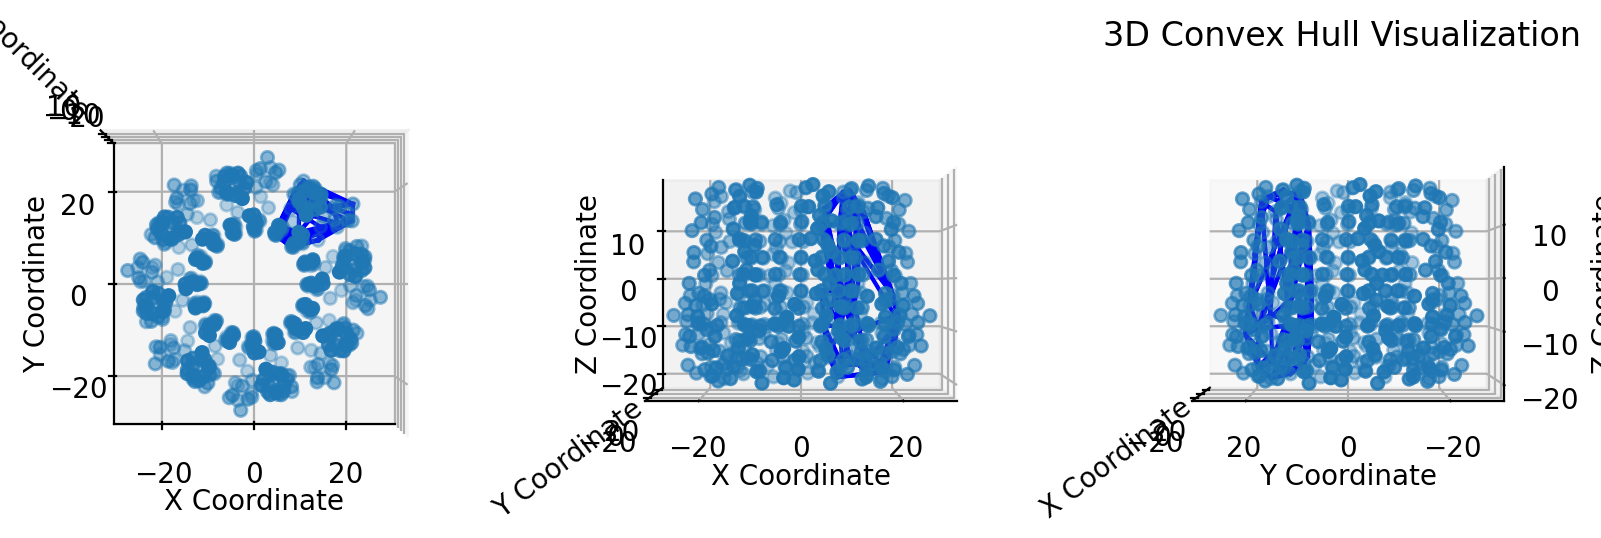

In [5]:
# Plotting
points = ca_coords
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

ax1.view_init(elev=90, azim=270)  # Top view
ax2.view_init(elev=0, azim=270)   # Front view
ax3.view_init(elev=0, azim=180)   # Side view

# Plot the points
ax1.scatter(points[:,0], points[:,1], points[:,2])
ax2.scatter(points[:,0], points[:,1], points[:,2])
ax3.scatter(points[:,0], points[:,1], points[:,2])

# Plot the convex hull
for simplex in hull.simplices:
    ax1.plot(points[simplex, 0], points[simplex, 1], points[simplex, 2], 'b-')
    ax2.plot(points[simplex, 0], points[simplex, 1], points[simplex, 2], 'b-')
    ax3.plot(points[simplex, 0], points[simplex, 1], points[simplex, 2], 'b-')

# # Labeling and showing the plot
ax1.set_xlabel('X Coordinate')
ax1.set_ylabel('Y Coordinate')
ax1.set_zlabel('Z Coordinate')
ax2.set_xlabel('X Coordinate')
ax2.set_ylabel('Y Coordinate')
ax2.set_zlabel('Z Coordinate')
ax3.set_xlabel('X Coordinate')
ax3.set_ylabel('Y Coordinate')
ax3.set_zlabel('Z Coordinate')
plt.title('3D Convex Hull Visualization')
plt.show()

In [6]:
import numpy as np
from scipy.spatial.transform import Rotation as R

def compute_pie_vertices(min_x, max_x, angle_deg, rotation_deg, z_min, z_max):
    angle_rad = np.deg2rad(angle_deg)
    offset_rad = np.deg2rad(rotation_deg)
    rots = [R.from_rotvec(np.array([0, 0, offset_rad+theta])).as_matrix() for theta in np.linspace(0, angle_rad, 3)]

    _vertices = np.array([[min_x, 0, z_min], [max_x, 0, z_min], [min_x, 0, z_max], [max_x, 0, z_max]])    
    vertices = np.concatenate([np.einsum("ij, nj -> ni", r, _vertices) for r in rots])
    return vertices

Text(0.5, 0, 'Z Coordinate')

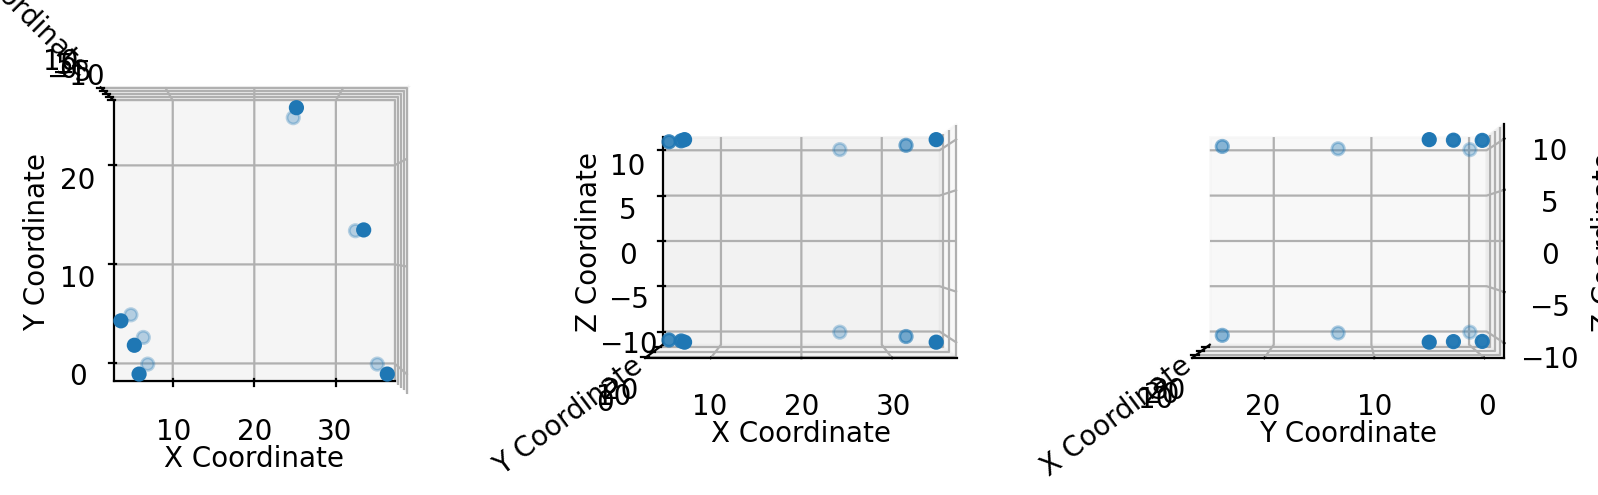

In [7]:
min_x, max_x = 7, 35
angle_deg = 45  # 90 degrees pie
rotation_deg = 0  # Rotate 45 degrees around the z-axis
z_min, z_max = -10, 10

vertices = compute_pie_vertices(min_x, max_x, angle_deg, rotation_deg, z_min, z_max)
# hull = ConvexHull(vertices)
# mesh = trimesh.Trimesh(vertices=vertices, faces=hull.simplices)

fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

ax1.view_init(elev=90, azim=270)  # Top view
ax2.view_init(elev=0, azim=270)   # Front view
ax3.view_init(elev=0, azim=180)   # Side view

# Plot the points
ax1.scatter(vertices[:,0], vertices[:,1], vertices[:,2])
ax2.scatter(vertices[:,0], vertices[:,1], vertices[:,2])
ax3.scatter(vertices[:,0], vertices[:,1], vertices[:,2])

ax1.set_xlabel('X Coordinate')
ax1.set_ylabel('Y Coordinate')
ax1.set_zlabel('Z Coordinate')
ax2.set_xlabel('X Coordinate')
ax2.set_ylabel('Y Coordinate')
ax2.set_zlabel('Z Coordinate')
ax3.set_xlabel('X Coordinate')
ax3.set_ylabel('Y Coordinate')
ax3.set_zlabel('Z Coordinate')

In [15]:
import torch
from rfdiffusion.inference.lbdd_utils import condition_map, prepare_mesh

In [37]:
mesh = trimesh.Trimesh(vertices=vertices, faces=hull.simplices)
guidance_dict = dict(ligand_volumes=prepare_mesh(mesh))
guidance_config = dict(pocket_margin=0.4, push_inside_margin=0.4)

clean_sample = 15 * torch.randn(1, 150, 3) + torch.tensor([5, 5, 0]).float().unsqueeze(0)

mask = torch.ones(1, 150).bool()
guidance_target = condition_map(pred_clean_sample=clean_sample.clone(), node_mask=mask, guidance_dict=guidance_dict, guidance_config=guidance_config)
guidance_target = guidance_target.cpu().numpy().squeeze()
clean_sample = clean_sample.cpu().numpy().squeeze()


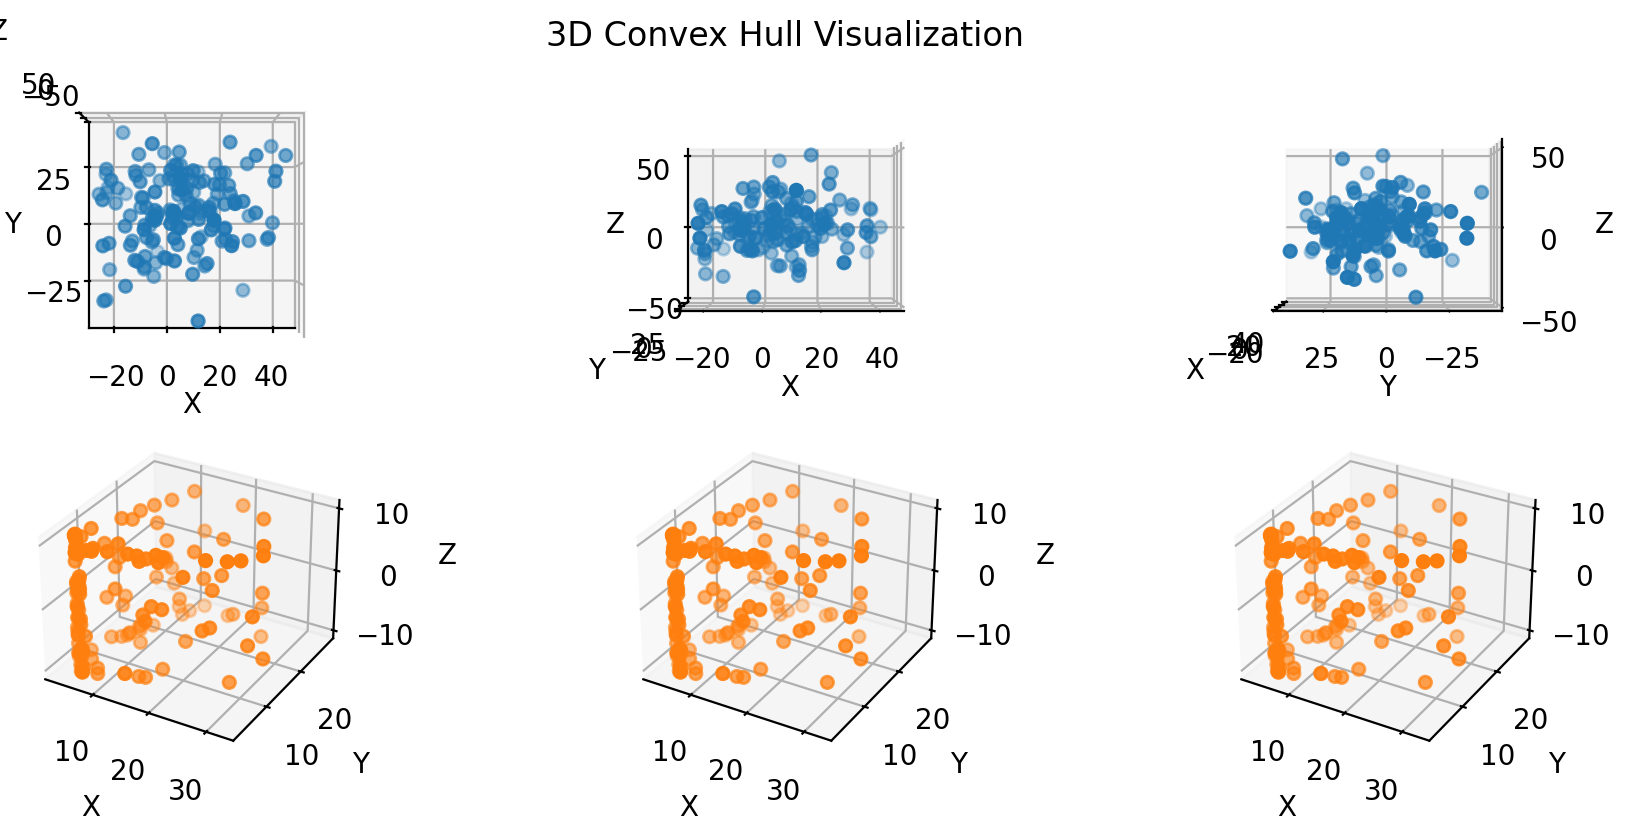

In [42]:
# Plotting
points = ca_coords
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(231, projection='3d')
ax2 = fig.add_subplot(232, projection='3d')
ax3 = fig.add_subplot(233, projection='3d')
ax4 = fig.add_subplot(234, projection='3d')
ax5 = fig.add_subplot(235, projection='3d')
ax6 = fig.add_subplot(236, projection='3d')

ax1.view_init(elev=90, azim=270)  # Top view
ax2.view_init(elev=0, azim=270)   # Front view
ax3.view_init(elev=0, azim=180)   # Side view

# Plot the points
ax1.scatter(clean_sample[:,0], clean_sample[:,1], clean_sample[:,2])
ax2.scatter(clean_sample[:,0], clean_sample[:,1], clean_sample[:,2])
ax3.scatter(clean_sample[:,0], clean_sample[:,1], clean_sample[:,2])
ax4.scatter(guidance_target[:,0], guidance_target[:,1], guidance_target[:,2], color='C1')
ax5.scatter(guidance_target[:,0], guidance_target[:,1], guidance_target[:,2], color='C1')
ax6.scatter(guidance_target[:,0], guidance_target[:,1], guidance_target[:,2], color='C1')

# # Labeling and showing the plot
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('Z')
ax4.set_xlabel('X')
ax4.set_ylabel('Y')
ax4.set_zlabel('Z')
ax5.set_xlabel('X')
ax5.set_ylabel('Y')
ax5.set_zlabel('Z')
ax6.set_xlabel('X')
ax6.set_ylabel('Y')
ax6.set_zlabel('Z')
ax2.set_title('3D Convex Hull Visualization')
plt.tight_layout()
plt.show()